In [2]:
import os 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp
import time

import gzip

import sys
sys.path.insert(-1, '/projectnb/encore/sofyaga/promoters_position_dependency/' )
import gtf_parser as gtfp
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# promoter_db = pd.read_csv('promoters_from_hit.csv', sep = '\t')
# promoter_db['promoter_id'] = promoter_db.apply(lambda row: 
#                              row['chromosome']+':'+str(row['genome_start'])+'-'+str(row['genome_end']), 
#                              axis = 1)

In [5]:
snp_dir = './gtex_snp/'
filename = 'GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.vcf.gz'
vcfsnp_columns = list()

with gzip.open(snp_dir + filename,'r') as fin:        
    for line in tqdm(fin):  
        decoded = line.decode()

        if decoded.startswith('#CHROM'):
            vcfsnp_columns = decoded[1:].strip().split()
            break
            

3385it [00:00, 97355.34it/s]


In [7]:

N = 0
for col in vcfsnp_columns:
    if col.startswith('GTEX'):
        N += 1

In [8]:
N

838

In [5]:
def parse_snp_data(bed_db):
    
# bed_db = promoter_db

    bed_coordinates = dict()
    for chrom, bed_group in bed_db.groupby('chromosome'):
        bed_coordinates[chrom] = bed_group[['genome_start', 'genome_end']].values


    snp_dir = './gtex_snp/'
    filename = 'GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.vcf.gz'

    curr_chr = 'chr1'
    curr_idx = 0
    rS, rE = bed_coordinates[curr_chr][curr_idx]
    region_lines = list()

    intersection_results = dict()

    # only assumption about intersections:
    # an entry might only intersect one other  entry on each side

    vcfsnp_columns = list()

    with gzip.open(snp_dir + filename,'r') as fin:        
        for line in tqdm(fin):  
            decoded = line.decode()

            if decoded.startswith('#CHROM'):
                vcfsnp_columns = decoded[1:].strip().split()
            if decoded.startswith('#'):
                continue

            splitted = decoded.strip().split()
            vchr, vpos = splitted[0], int(splitted[1])

    #             # this is preliminary
            

            if vchr != curr_chr:
                if vchr not in ['chr1', 'chr2']:
                    break
                curr_idx = 0
                curr_chr = vchr
                print(curr_chr)
                rS, rE = bed_coordinates[curr_chr][curr_idx]
                region_lines = list()


            if curr_idx == len(bed_coordinates[curr_chr]):
                continue

            while vpos > rE:
                curr_idx += 1

                 #SAVE gene lines for the previous gene
                intersection_results[f'{curr_chr}:{rS}-{rE}'] = region_lines

                if curr_idx == len(bed_coordinates[curr_chr]):
                    break


                # NEW elem:
                rS, rE = bed_coordinates[curr_chr][curr_idx]
#                 region_lines = list()

#                 # SAVE some previous lines 
                region_lines = [snp_line for snp_line in region_lines if int(snp_line[1]) >= rS]

#                 assert rS < rE


            if curr_idx == len(bed_coordinates[curr_chr]):
                continue


            if vpos < rS:
                continue

#             assert vpos >= rS
#             if vpos > rE:
#                 print('ERROR in while cycle')
#                 if curr_idx == len(bed_coordinates[curr_chr]):
#                     print('a no not error')
#                     continue

#             assert vpos <= rE
            splitted.extend([rS, rE, curr_chr])
            region_lines.append(splitted)
        
    if f'{curr_chr}:{rS}-{rE}' not in intersection_results:
            intersection_results[f'{curr_chr}:{rS}-{rE}'] = region_lines
            
    return intersection_results


tt = time.time()
intersection_results = parse_snp_data(promoter_db)
print(time.time() - tt)

7474194it [07:19, 16990.14it/s]

440.1690835952759


In [6]:
print('hello')

hello


In [13]:
# I really need to rewrite this to Parquet or https://docs.h5py.org/en/stable/quick.html#quick storage 
# hdf5 format!!!

string_to_copies_dict = {'0|0': 0, '0|1': 1, '1|0': 1, '1|1': 2, '.|.': 0}

with open('snps_in_promoters.tsv', 'w') as fout:
    for promoter in intersection_results:
        for snp_line in intersection_results[promoter]:
            output = [str(string_to_copies_dict[elem]) if elem in string_to_copies_dict else str(elem) 
                      for elem in snp_line[:-3] ]
            fout.write(f'{promoter}\t')
            fout.write('\t'.join(output))
            fout.write('\n')

# these are stress tests, so ignore these

In [7]:
for p in tqdm(intersection_results):
    new_snp_lines = list()
    chromosome = p.split(':')[0]
    for snp_line in intersection_results[p]:
        if snp_line[-1] == chromosome:
             new_snp_lines.append(snp_line)
        else:
            print('error, collected data from additional chromosomes....')

100%|██████████| 13511/13511 [00:00<00:00, 36249.15it/s]


In [8]:
# this is a test that all promoters from chr2 and chr1 were covered 
promoters_intersected = list(intersection_results.keys())

temp = promoter_db
temp = temp[temp['chromosome'] == 'chr2']
for p in temp['promoter_id']:
    if p not in promoters_intersected:
        print(p)


In [38]:
# this is a stress test for first chromosome

n = 100000
full_data = list()


with gzip.open(snp_dir + filename,'r') as fin:        
    for line in tqdm(fin):  
        decoded = line.decode()

        if decoded.startswith('#CHROM'):
            vcfsnp_columns = decoded[1:].strip().split()
        if decoded.startswith('#'):
            continue

        splitted = decoded.strip().split()
        full_data.append(splitted[:2])
        n-= 1
        if n == 0:
            break
            
            

full_data_df = pd.DataFrame(full_data)
full_data_df[1] = full_data_df[1].astype(int)

lengths = list()
snps = list()

for region in tqdm(intersection_results.keys()):
    chrom, cords = region.split(':')
    cords = cords.split('-')
    rs, re = int(cords[0]), int(cords[1])
    
    if re > 5377431:
        continue
        
    answer = full_data_df
    answer = answer[answer[1] <= re]
    answer = answer[answer[1] >= rs]
    
    
    correct_positions = answer[1].values
    if len(correct_positions) == 0:
        continue
    check_positions = pd.DataFrame(intersection_results[region])[1].astype(int).values
    
    lengths.append(len(answer) == len(intersection_results[region]))
    snps.append(set(correct_positions) == set(check_positions))

  4%|▍         | 128/3044 [01:20<30:40,  1.58it/s]


KeyboardInterrupt: 

# now a bit about what we collected 

In [48]:
intersection_results


cleaned_intersection_results = dict()

for p in tqdm(intersection_results):
    new_snp_lines = list()
    chromosome = p.split(':')[0]
    for snp_line in intersection_results[p]:
        if snp_line[-1] == chromosome:
             new_snp_lines.append(snp_line)
        else:
            print('error')
    cleaned_intersection_results[p] = new_snp_lines


100%|██████████| 77267/77267 [00:04<00:00, 17812.92it/s]


In [49]:
### RUN THIS CELL after ana!!!!!!!!!!!!!!!!!
string_to_copies_dict = {'0|0': 0, '0|1': 1, '1|0': 1, '1|1': 2, '.|.': 0}



with open('snps_in_promoters.tsv', 'w') as fout:
    for promoter in intersection_results:
        for snp_line in intersection_results[promoter]:
            output = [str(string_to_copies_dict[elem]) if elem in string_to_copies_dict else str(elem) 
                      for elem in snp_line[:-3] ]
            fout.write(f'{promoter}\t')
            fout.write('\t'.join(output))
            fout.write('\n')

In [54]:
def number_of_unique_snps(snp_lines):
    snp_pos = [snp_line[1] for snp_line in snp_lines]
    return len(set(snp_pos))

snp_numbers_unique = [number_of_unique_snps(cleaned_intersection_results[p]) for p in promoter_db.promoter_id 
                      if p in cleaned_intersection_results]  

def size_or_region(snp_lines):
    snp_pos = [int(snp_line[1]) for snp_line in snp_lines]
    if len(snp_pos) == 0:
        return 0
    return max(snp_pos) - min(snp_pos)


snp_numbers_unique = [number_of_unique_snps(cleaned_intersection_results[p]) for p in promoter_db.promoter_id 
                      if p in cleaned_intersection_results] 

region_sizes = [size_or_region(cleaned_intersection_results[p]) for p in promoter_db.promoter_id 
                      if p in cleaned_intersection_results] 

/usr3/graduate/sofyaga/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 0, 'Number of snps per 1000nt promoter')

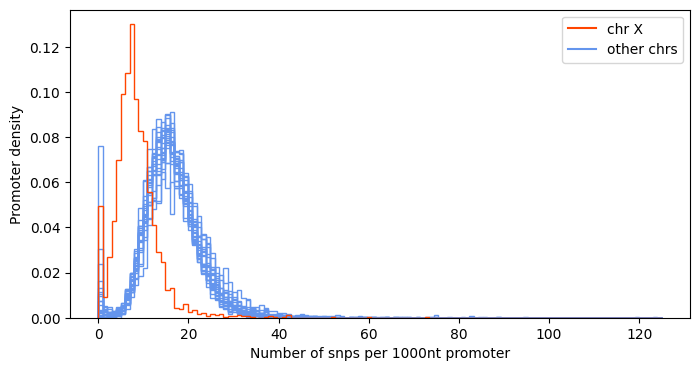

In [83]:
plt.figure(figsize = (8, 4))


for chromosome, group in promoter_db.groupby('chromosome'):
    
    snp_numbers_unique = [number_of_unique_snps(cleaned_intersection_results[p]) for p in group.promoter_id 
                      if p in intersection_results]
    
    if chromosome == 'chrX':
        color = 'orangered'
    else:
        color = 'cornflowerblue'
        
#     print(chromosome)
#     print(np.mean(snp_numbers_unique), np.median(snp_numbers_unique))

    plt.hist(snp_numbers_unique, range = (0, 125), bins = 126, histtype = 'step', label = chromosome, 
            density = True, color = color);

plt.legend(handles=[Line2D([0], [0], label='chr X', color='orangered'), 
                   Line2D([0], [0], label='other chrs', color='cornflowerblue')])

plt.ylabel('Promoter density')
plt.xlabel('Number of snps per 1000nt promoter')

In [ ]:
NUmber of snps per 1000nt promoter: 15-17 
for X chromosome: 7-8

/usr3/graduate/sofyaga/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr3/graduate/sofyaga/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 0, 'Number of snps per 250nt promoter')

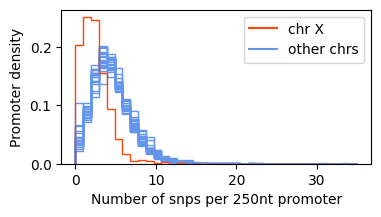

In [81]:
def number_of_snps_in_short_promoter(snp_lines, ori, pstart, pend, size = 250):
    
    
    start = pstart
    end = pend
    if ori == '+':
        start = end - size
    if ori == '-':
        end = start + size
        
    snp_positions = [int(snp_line[1]) for snp_line in snp_lines]

    shorter = [pos for pos in snp_positions if ((pos <= end) and (pos >= start))]
    
    return len(set(shorter))






plt.figure(figsize = (4, 2))


for chromosome, group in promoter_db.groupby('chromosome'):
    
    snp_numbers_unique = [
        number_of_snps_in_short_promoter(cleaned_intersection_results[p], ori, pstart, pend) 
        for (p, ori, pstart, pend) in group[['promoter_id', 'ori', 'genome_start', 'genome_end']].values
        if p in intersection_results]
    
#     print(chromosome)
#     print(np.mean(snp_numbers_unique), np.median(snp_numbers_unique))
# #     print(np.m)
    
    if chromosome == 'chrX':
        color = 'orangered'
    else:
        color = 'cornflowerblue'

    plt.hist(snp_numbers_unique, range = (0, 35), bins = 36, histtype = 'step', label = chromosome, 
            density = True, color = color);

plt.legend(handles=[Line2D([0], [0], label='chr X', color='orangered'), 
                   Line2D([0], [0], label='other chrs', color='cornflowerblue')])

plt.ylabel('Promoter density')
plt.xlabel('Number of snps per 250nt promoter')

Median (and mean) number of snps per 250nt promoter is 4. For X chromosome -- 2. 


How do I store the data??

https://www.pytables.org/
https://docs.h5py.org/en/stable/index.html

    The two projects have different design goals. PyTables presents a database-like approach to data storage, providing features like indexing and fast “in-kernel” queries on dataset contents. It also has a custom system to represent data types.

In [9]:
proms = list(intersection_results.keys())

In [10]:
proms[10000]

'chr2:88037051-88038051'

In [12]:
pd.DataFrame(intersection_results[proms[10000]])

,0,1,2,3,4,5,6,7,8,9,...,840,841,842,843,844,845,846,847,848,849
0,chr2,88037213,chr2_88037213_A_G_b38,A,G,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
1,chr2,88037230,chr2_88037230_A_G_b38,A,G,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
2,chr2,88037441,chr2_88037441_TG_T_b38,TG,T,.,PASS,AN=1676;AF=0.00536993;AC=9,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
3,chr2,88037475,chr2_88037475_A_T_b38,A,T,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
4,chr2,88037569,chr2_88037569_T_C_b38,T,C,.,PASS,AN=1676;AF=0.00238663;AC=4,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
5,chr2,88037718,chr2_88037718_T_C_b38,T,C,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
6,chr2,88037878,chr2_88037878_T_C_b38,T,C,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
7,chr2,88037895,chr2_88037895_G_A_b38,G,A,.,PASS,AN=1676;AF=0.903938;AC=1515,GT,1|1,...,1|1,1|1,1|1,1|1,1|1,1|1,1|1,88037051,88038051,chr2
8,chr2,88037974,chr2_88037974_A_G_b38,A,G,.,PASS,AN=1676;AF=0.00238663;AC=4,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2
9,chr2,88038017,chr2_88038017_G_A_b38,G,A,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,88037051,88038051,chr2


In [18]:
promoter_db

,gene,chromosome,gene_start,gene_end,ori,tss_pos,origin,genome_start,genome_end,promoter_id
0,ENSG00000186092.4,chr1,69091,70008,+,69091,annotation_start,68091,69091,chr1:68091-69091
1,ENSG00000278566.1,chr1,450740,451678,-,451678,annotation_start,451678,452678,chr1:451678-452678
2,ENSG00000273547.1,chr1,685716,686654,-,686654,annotation_start,686654,687654,chr1:686654-687654
3,ENSG00000187634.11,chr1,923928,944581,+,923928,hit,922928,923928,chr1:922928-923928
4,ENSG00000187634.11,chr1,923928,944581,+,925922,hit,924922,925922,chr1:924922-925922
...,...,...,...,...,...,...,...,...,...,...
78148,ENSG00000185894.8,chrY,25030901,25062548,-,25062548,annotation_start,25062548,25063548,chrY:25062548-25063548
78149,ENSG00000172288.7,chrY,25622162,25624902,+,25622162,annotation_start,25621162,25622162,chrY:25621162-25622162
78150,ENSG00000168939.11_PAR_Y,chrY,56954332,56968979,+,56954332,annotation_start,56953332,56954332,chrY:56953332-56954332
78151,ENSG00000124333.15_PAR_Y,chrY,57067813,57130289,+,57067813,annotation_start,57066813,57067813,chrY:57066813-57067813


In [22]:
promoter_db_temp =promoter_db[promoter_db['chromosome'].isin(['chr1', 'chr2'])]

for gene, promoter_group in tqdm(promoter_db_temp.groupby('gene')):
#     if gene not in genes_with_exons:
#         continue
        
    snp_df = list()    
    for promoter in promoter_group['promoter_id']:
        
        snp_df.append(pd.DataFrame(intersection_results[promoter], 
                                  columns = promoter_region_columns))
        
        
    snp_df = pd.concat(snp_df).reset_index(drop = True)
    string_to_copies_dict = {'0|0': 0, '0|1': 1, '1|0': 1, '1|1': 2, '.|.': 0}
    if len(snp_df) == 0:
        continue
    
    sample_columns = list()

    for col in promoter_region_columns:
        if col.startswith('GTEX'):
            sample_columns.append(col)
        
    snp_df[sample_columns] = np.array(
            [[string_to_copies_dict[v] for v in varr] 
             for varr in snp_df[sample_columns].values])
    
    break

    

  0%|          | 0/3275 [00:00<?, ?it/s]


In [15]:

sample_columns = list()
info_columns = list()
for name in snp_df.columns:
    if name.startswith('GTEX'):
        sample_columns.append(name)
    else:
        info_columns.append(name)

NameError: name 'snp_df' is not defined

In [29]:
snp_df[info_columns]

to_store = ['ID', 'CHROM', 'POS', 'INFO', 'promoter_start', 'promoter_end']
snp_df[to_store]

,ID,CHROM,POS,INFO,promoter_start,promoter_end
0,chr1_169854999_G_A_b38,chr1,169854999,AN=1676;AF=0.000596659;AC=1,169854964,169855964
1,chr1_169855022_T_C_b38,chr1,169855022,AN=1676;AF=0.000596659;AC=1,169854964,169855964
2,chr1_169855049_G_T_b38,chr1,169855049,AN=1676;AF=0.000596659;AC=1,169854964,169855964
3,chr1_169855057_G_C_b38,chr1,169855057,AN=1676;AF=0.000596659;AC=1,169854964,169855964
4,chr1_169855062_A_G_b38,chr1,169855062,AN=1676;AF=0.0865155;AC=145,169854964,169855964
...,...,...,...,...,...,...
206,chr1_169894905_TAATAAG_T_b38,chr1,169894905,AN=1676;AF=0.000596659;AC=1,169893959,169894959
207,chr1_169894949_TATG_T_b38,chr1,169894949,AN=1676;AF=0.000596659;AC=1,169893959,169894959
208,chr1_169894950_A_G_b38,chr1,169894950,AN=1674;AF=0.00119474;AC=2,169893959,169894959
209,chr1_169894990_A_G_b38,chr1,169894990,AN=1676;AF=0.000596659;AC=1,169894267,169895267


In [31]:
snp_df[sample_columns].T

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
GTEX-1117F,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
GTEX-111CU,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
GTEX-111FC,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
GTEX-111VG,0,0,0,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
GTEX-111YS,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZYW4,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
GTEX-ZYY3,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
GTEX-ZZ64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GTEX-ZZPT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
len(promoter_db_temp['gene'].unique())

3275

In [9]:
import tables as tb

In [ ]:
class SnpInfo(tb.IsDescription):
    name      = StringCol(16)   # 16-character String
    idnumber  = Int64Col()      # signed 64-bit integer
    ADCcount  = UInt16Col()     # unsigned short integer
    TDCcount  = UInt8Col()      # unsigned byte
    grid_i    = Int32Col()      # integer
    grid_j    = Int32Col()      # integer

# class SnpInSamples(tb.IsDescription):
    
#     # A sub-structure (nested data-type)
#     class Properties(IsDescription):
#         pressure = Float32Col(shape=(2,3)) # 2-D float array (single-precision)
#         energy   = Float64Col(shape=(2,3,4)) # 3-D float array (double-precision)

In [13]:
promoter_db_temp =promoter_db[promoter_db['chromosome'].isin(['chr1', 'chr2'])]

In [42]:
# # Open a file in "w"rite mode
# h5file = tb.open_file("snps_chr1_2.h5", mode="w", title="SNP data for chr1 and chr2")

# # Get the HDF5 root group
# root = h5file.root

# # Create the groups
# for gene_id in tqdm(promoter_db_temp['gene'].unique()):
#     h5file.create_group(root, gene_id.replace('.', '_'))

# # Now, create an array in root group
# array = h5file.create_array(root, "sample_columns", sample_columns)

# # # Create new tables in group1
# for gene_id in tqdm(promoter_db_temp['gene'].unique()):
    
#     table = fileh.create_table(f'/{gene_id}', "snp_info", SnpInfo)

#     # Now, fill the table

#     # Get the record object associated with the table:
#     row = table.row

#     # Fill the table with 10 records
#     for i in range(10):
#         # First, assign the values to the Particle record
#         row['identity']  = f'This is particle: {i:2d}'
#         row['idnumber'] = i
#         row['speed']  = i * 2.

#         # This injects the Record values
#         row.append()

#     # Flush the table buffers
#     table.flush()

# # Finally, close the file (this also will flush all the remaining buffers!)
# h5file.close()

100%|██████████| 3275/3275 [00:00<00:00, 4507.46it/s]


In [17]:

sample_columns = list()
for elem in vcfsnp_columns:
    if elem.startswith('GTEX'):
        sample_columns.append(elem)

In [24]:
with tb.open_file("snps_chr1_2.h5", mode="w", title="SNP data for chr1 and chr2") as  h5file:

    root = h5file.root
    for gene_id in tqdm(promoter_db_temp['gene'].unique()):
        h5file.create_group(root, gene_id.replace('.', '_'))
    array = h5file.create_array(root, "sample_columns", sample_columns)



    for gene, promoter_group in tqdm(promoter_db_temp.groupby('gene')):
        gene_id = gene.replace('.', '_')

        snp_df = list()    
        for promoter in promoter_group['promoter_id']:

            snp_df.append(pd.DataFrame(intersection_results[promoter], 
                                      columns = promoter_region_columns))


        snp_df = pd.concat(snp_df).reset_index(drop = True)
        string_to_copies_dict = {'0|0': 0, '0|1': 1, '1|0': 1, '1|1': 2, '.|.': 0}
        if len(snp_df) == 0:
            continue

        sample_columns = list()

        for col in promoter_region_columns:
            if col.startswith('GTEX'):
                sample_columns.append(col)

        snp_df[sample_columns] = np.array(
                [[string_to_copies_dict[v] for v in varr] 
                 for varr in snp_df[sample_columns].values])



        snp_ids = snp_df['ID'].values
        sample_values = snp_df[sample_columns].values
        covered = list()

        for idx, snp_id in enumerate(snp_ids):
            if snp_id in covered:
                continue
            h5file.create_array(f'/{gene_id}', snp_id, sample_values[idx])
            covered.append(snp_id)

        
h5file.close()

100%|██████████| 3275/3275 [30:26<00:00,  1.79it/s]  


In [71]:
h5file.close()

In [73]:
20000/155

129.03225806451613

In [61]:
snp_df[snp_df['ID'] == 'chr1_169894328_C_T_b38']

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,GTEX-1117F,...,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPT,GTEX-ZZPU,promoter_start,promoter_end,promoter_chr
187,chr1,169894328,chr1_169894328_C_T_b38,C,T,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0,...,0,0,0,0,0,0,0,169893959,169894959,chr1
198,chr1,169894328,chr1_169894328_C_T_b38,C,T,.,PASS,AN=1676;AF=0.000596659;AC=1,GT,0,...,0,0,0,0,0,0,0,169893959,169894959,chr1


In [58]:
h5file.close()

# THIS will go to the other notebook!!!!
the one that is collect_gene_entries 

In [84]:
# annotation

# get the tissue list
tissues = os.listdir('/projectnb/encore/gtex/data/')

lengths = list()
for tis in tissues:
    lengths.append(len(os.listdir(f'/projectnb/encore/gtex/data/{tis}')))
    
    
# And the list of samples analyzed    
tissues_to_samples = dict()

for tissue in tqdm(tissues):
    tissues_to_samples[tissue] = list()
    runs = [run for run in os.listdir(f'/projectnb/encore/gtex/data/{tissue}/') if ('.json' not in run)]
    for run_id in runs[:20]:
        tissues_to_samples[tissue].append(run_id)

100%|██████████| 54/54 [00:00<00:00, 4849.74it/s]


In [23]:
promoter_region_columns = list(vcfsnp_columns[:])
promoter_region_columns.extend(['promoter_start', 'promoter_end', 'promoter_chr'])


In [210]:
     
class RmatsGene(gtfp.GTFGene):
    def __init__(self, gene_id, chromosome, start, end, ori): 
        super().__init__(gene_id, chromosome, start, end, ori)
        
        self.rmats_data = pd.DataFrame(columns = ['sample_id', 
                                                'exonStart_0base', 'exonEnd', 
               'upstreamES', 'upstreamEE', 'downstreamES', 'downstreamEE',
               'IJC_SAMPLE_1', 'SJC_SAMPLE_1', 'IncLevel1'])

        self.rmats_row_buffer = list()
    
    def add_rmats_row_to_buffer(self, rmats_row):
        self.rmats_row_buffer.append(rmats_row)
        
    def dump_rmats_data_buffer(self):
        new_rmats_data = pd.DataFrame(self.rmats_row_buffer, 
                                     columns = ['sample_id', 'exonStart_0base', 'exonEnd', 
                   'upstreamES', 'upstreamEE', 'downstreamES', 'downstreamEE',
                   'IJC_SAMPLE_1', 'SJC_SAMPLE_1', 
                   'IncLevel1'])
        self.rmats_data = pd.concat([self.rmats_data, new_rmats_data], ignore_index = True)
        self.rmats_row_buffer = list()
        
        integer_cols = ['exonStart_0base', 'exonEnd', 'upstreamES', 'upstreamEE', 
                        'downstreamES', 'downstreamEE', 'IJC_SAMPLE_1', 'SJC_SAMPLE_1']
        float_cols = ['IncLevel1']
        str_cols = ['sample_id']
        self.rmats_data[integer_cols] = self.rmats_data[integer_cols].astype(int)
        self.rmats_data[float_cols] = self.rmats_data[float_cols].astype(float)
        self.rmats_data[str_cols] = self.rmats_data[str_cols].astype(str)

        
        
class SNPRmatsGene(RmatsGene):
    def __init__(self, gene_id, chromosome, start, end, ori): 
        super().__init__(gene_id, chromosome, start, end, ori)
        self.snp_data = pd.DataFrame()
        
    def add_promoter_snp_data(self, cleaned_intersection_results, promoter, promoter_region_columns):
        new_promoter_data = pd.DataFrame(cleaned_intersection_results[promoter], 
            columns = promoter_region_columns)
    
        self.sample_columns = list()

        for col in promoter_region_columns:
            if col.startswith('GTEX'):
                self.sample_columns.append(col)
        
        string_to_copies_dict = {'0|0': 0, '0|1': 1, '1|0': 1, '1|1': 2, '.|.': 0}
        if len(new_promoter_data) == 0:
            return 

        new_promoter_data[self.sample_columns] = np.array(
            [[string_to_copies_dict[v] for v in varr] 
             for varr in new_promoter_data[self.sample_columns].values])
        
        self.snp_data = pd.concat([self.snp_data, new_promoter_data]).reset_index(drop = True)
    

    def merge_snp_w_rmats(self):
        if len(self.rmats_data) == 0:
            return 

        sample_columns = self.sample_columns
        values_transposed = self.snp_data[sample_columns].values.T
        self.snp_ids = self.snp_data['ID'].values
        
        snp_df_transposed = pd.DataFrame(values_transposed, 
                                           columns = self.snp_ids)
        snp_df_transposed['short_sample_name'] = self.sample_columns
        
        self.rmats_data['short_sample_name'] = self.rmats_data.apply(lambda row:
                                               '-'.join(row['sample_id'].split('-')[:2]), 
                                                        axis = 1)

        self.rmats_data = self.rmats_data.merge(snp_df_transposed, how = 'left', 
                           on = 'short_sample_name')


    # return difference, pval, lengths
    def get_influence_stats(data1, data2):
        l1, l2 = len(data1), len(data2)
        if l1*l2 == 0:
            return [np.nan, np.nan, l1, l2]
        difference = np.mean(data1) - np.mean(data2)
        return [difference, ks_2samp(data1, data2).pvalue, l1, l2]

    
#     def get_snp_correlation(self):
        
#         snp_change = list()

#         for (exon_start, exon_end), group in self.rmats_data.groupby(['exonStart_0base', 'exonEnd']):
#             y = group['IncLevel1']
            
#             for snp in self.snp_ids:
                
# #                 if self.snp_near_promoter(snp) == False:
# #                     break
                    
                    
#                 x = group[snp].values
#                 yna = y[~np.isnan(x)]
#                 xna = x[~np.isnan(x)]


#                 if sum(xna) == 0:
#                     continue

#                 y0snp = yna[xna == 0]
#                 y1snp = yna[xna == 1]
#                 y2snp = yna[xna == 2]
#                 y12snp = yna[xna > 0]

#                 result = [exon_start, exon_end, snp]
#                 result.extend( get_influence_stats(y0snp, y12snp))
#                 result.extend( get_influence_stats(y0snp, y1snp))
#                 result.extend( get_influence_stats(y1snp, y2snp))

#                 snp_change.append(result)


#         self.snp_correlation = pd.DataFrame(snp_change, columns = ['exon_start', 'exon_end', 'snpID', 
#                                             'diff_0_12', 'pval_0_12', 'len_0', 'len_12', 
#                                             'diff_0_1', 'pval_0_1', 'len_0', 'len_1', 
#                                             'diff_1_2', 'pval_1_2', 'len_1', 'len_2'])

def get_snp_correlation(snp_gene):
        
    snp_change = list()

    for (exon_start, exon_end), group in snp_gene.rmats_data.groupby(['exonStart_0base', 'exonEnd']):
        y = group['IncLevel1'].values

        for snp in snp_gene.snp_ids:

#                 if self.snp_near_promoter(snp) == False:
#                     break


            x = group[snp].values
            if len(x.shape) == 2:
                x = x.T[0]

            yna = y[~np.isnan(x)]
            xna = x[~np.isnan(x)]


            if sum(xna) == 0:
                continue

            y0snp = yna[xna == 0]
            y1snp = yna[xna == 1]
            y2snp = yna[xna == 2]
            y12snp = yna[xna > 0]

            result = [exon_start, exon_end, snp]
            result.extend( get_influence_stats(y0snp, y12snp))
            result.extend( get_influence_stats(y0snp, y1snp))
            result.extend( get_influence_stats(y1snp, y2snp))

            snp_change.append(result)


    snp_gene.snp_correlation = pd.DataFrame(snp_change, columns = ['exon_start', 'exon_end', 'snpID', 
                                        'diff_0_12', 'pval_0_12', 'len_0', 'len_12', 
                                        'diff_0_1', 'pval_0_1', 'len_0', 'len_1', 
                                        'diff_1_2', 'pval_1_2', 'len_1', 'len_2'])
        

        
def get_sorted_gene_coordinates(genes_with_exons, promoter_buffer = 1000): 
    
    gene_coordinates = list()
    for gene in genes_with_exons:
        ent = genes_with_exons[gene]
        chromosome, s, e, ori, gene_id = ent.chromosome, ent.gene_start, ent.gene_end, ent.ori, ent.gene_id
        assert s < e
        if ori == '+':
            s -= promoter_buffer
        else:
            e += promoter_buffer
            
        gene_coordinates.append([chromosome, s, e, gene_id])
    gene_coordinates = sorted(gene_coordinates, key = lambda elem: (elem[0], elem[1]))
    
    return gene_coordinates
    
        
def parse_rmats_sample(path_to_sample_dir, sample_id):
    
    temp = pd.read_csv(f'{path_to_sample_dir}SE.MATS.JC.txt', sep = '\t')
    temp['sample_id'] = sample_id
    
    
    for gene, group in temp.groupby('GeneID'):
        if gene in genes_with_exons:
            
            for rmats_row in group[['sample_id', 'exonStart_0base', 'exonEnd', 
                   'upstreamES', 'upstreamEE', 'downstreamES', 'downstreamEE',
                   'IJC_SAMPLE_1', 'SJC_SAMPLE_1', 
                   'IncLevel1']].values:
                genes_with_exons[gene].add_rmats_row_to_buffer(rmats_row)
                

            
            
# gencode_annotation_path ='/projectnb/encore/gtex/refs/hg38_gencode-v26/hg38_gencode-v26.gtf'
# genes_with_exons = gtfp.process_gtf_for_first_exons(gencode_annotation_path, num_genes=1000, 
#                                                    geneclass = SNPRmatsGene)
# print(f'Number of protein-coding genes loaded from annotation: {len(genes_with_exons)}')




# for sample_id in tqdm(os.listdir('/projectnb/encore/gtex/data/lung/')[2:]):
#     if '.' in sample_id:
#         continue

    
#     path_to_sample_dir = f'/projectnb/encore/gtex/data/lung/{sample_id}/rmats/'
#     parse_rmats_sample(path_to_sample_dir, sample_id)

In [119]:
def get_influence_stats(data1, data2):
    l1, l2 = len(data1), len(data2)
    if l1*l2 == 0:
        return [np.nan, np.nan, l1, l2]
    difference = np.mean(data1) - np.mean(data2)
    return [difference, ks_2samp(data1, data2).pvalue, l1, l2]

In [168]:
for gene, promoter_group in tqdm(promoter_db.groupby('gene')):
    if gene not in genes_with_exons:
        continue
        
    snp_df = list()    
    for promoter in promoter_group['promoter_id']:
        
        snp_df.append(pd.DataFrame(cleaned_intersection_results[promoter], 
                                  columns = promoter_region_columns))
        
        
    snp_df = pd.concat(snp_df).reset_index(drop = True)
    string_to_copies_dict = {'0|0': 0, '0|1': 1, '1|0': 1, '1|1': 2, '.|.': 0}
    if len(snp_df) == 0:
        continue
    
    sample_columns = list()

    for col in promoter_region_columns:
        if col.startswith('GTEX'):
            sample_columns.append(col)
        
    snp_df[sample_columns] = np.array(
            [[string_to_copies_dict[v] for v in varr] 
             for varr in snp_df[sample_columns].values])
    

    genes_with_exons[gene].snp_data = snp_df
    genes_with_exons[gene].sample_columns = sample_columns
                

100%|██████████| 19817/19817 [06:04<00:00, 54.31it/s] 


In [169]:
for sample_id in tqdm(os.listdir('/projectnb/encore/gtex/data/lung/')[2:]):
    if '.' in sample_id:
        continue
    
    path_to_sample_dir = f'/projectnb/encore/gtex/data/lung/{sample_id}/rmats/'
    parse_rmats_sample(path_to_sample_dir, sample_id)

100%|██████████| 572/572 [16:14<00:00,  1.70s/it] 


In [170]:
with open(r"snps_in_promoters.pickle", "wb") as output_file:
    pickle.dump(cleaned_intersection_results, output_file)

In [213]:
for gene in tqdm(list(genes_with_exons.keys())[11:]):
    genes_with_exons[gene].dump_rmats_data_buffer()    
    genes_with_exons[gene].merge_snp_w_rmats()
#     genes_with_exons[gene].get_snp_correlation()
    get_snp_correlation(genes_with_exons[gene])
    

 12%|█▏        | 114/989 [03:03<23:26,  1.61s/it] 


KeyboardInterrupt: 

In [198]:
for gene in tqdm(list(genes_with_exons.keys())[11:111]):

AttributeError: 'numpy.ndarray' object has no attribute 'dims'

In [217]:
gene = list(genes_with_exons.keys())[111]

In [250]:
genes_with_exons[gene].snp_correlation

for gene in list(genes_with_exons.keys())[11:111]:
    corr = genes_with_exons[gene].snp_correlation
    temp = corr[corr['pval_0_12'] < 0.001]
    if len(temp)> 0:
        print(gene)
        print(temp[['exon_start', 'exon_end', 'snpID']])

ENSG00000131591.17
     exon_start  exon_end                 snpID
537     1091277   1091374  chr1_1091327_C_A_b38
541     1091277   1091374  chr1_1091421_T_A_b38
ENSG00000215915.9
    exon_start  exon_end                 snpID
93     1454344   1454500  chr1_1455617_T_G_b38
ENSG00000160072.19
     exon_start  exon_end                 snpID
295     1490562   1490671  chr1_1471713_G_A_b38
ENSG00000008128.22
    exon_start  exon_end                     snpID
59     1716345   1716478      chr1_1724489_G_C_b38
61     1716345   1716478  chr1_1724661_CGATG_C_b38
75     1722587   1722634      chr1_1724360_T_C_b38
76     1722587   1722634      chr1_1724382_T_G_b38
ENSG00000215790.6
    exon_start  exon_end                  snpID
22     1744250   1744668   chr1_1735884_C_T_b38
25     1744250   1744668   chr1_1735980_A_C_b38
42     1744250   1744668   chr1_1736472_C_T_b38
45     1744250   1744668   chr1_1740017_C_T_b38
48     1744250   1744668   chr1_1740107_G_A_b38
49     1744250   1744668   chr

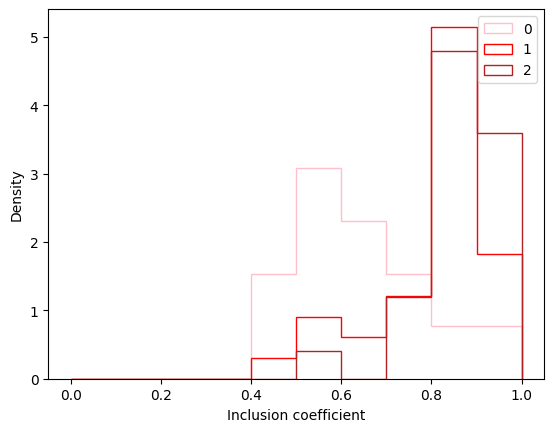

In [262]:
# gene = 'ENSG00000131591.17'
# plot_snp(genes_with_exons[gene].rmats_data, 1091277, 1091374, 'chr1_1091327_C_A_b38')
# gene  = 'ENSG00000142599.17'
# plot_snp(genes_with_exons[gene].rmats_data, 8423166, 8423247, 'chr1_8656484_G_C_b38', density =True)


# gene = 'ENSG00000158292.6'
# plot_snp(genes_with_exons[gene].rmats_data, 6251337, 6251530, 'chr1_6261142_C_T_b38', density = True)

gene = 'ENSG00000142606.15'
snpID = 'chr1_2633026_T_C_b38'
plot_snp(genes_with_exons[gene].rmats_data, 2591556, 2591633, snpID, density = True)


2591557 2591633
2633026


(2637990.0, 2585639.0)

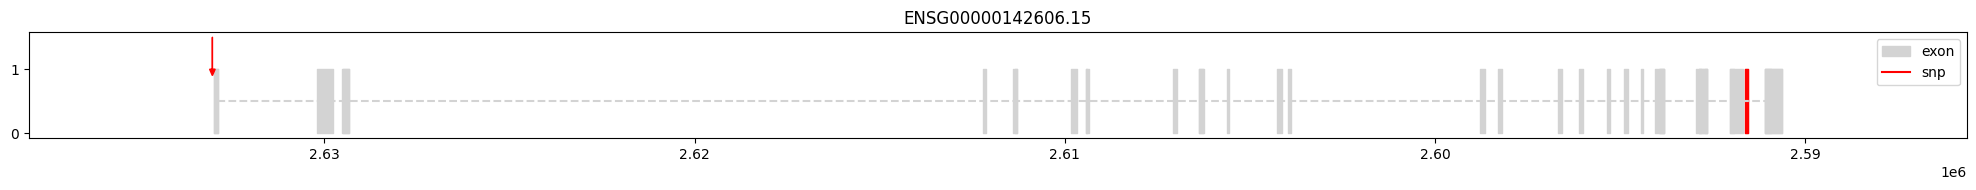

In [274]:
plt.figure(figsize = (20, 2))


S, E = genes_with_exons[gene].gene_start, genes_with_exons[gene].gene_end

plt.plot([S, E], [0.5, 0.5], color = 'lightgrey', linestyle = '--')

for s in genes_with_exons[gene].exons:
    for e in genes_with_exons[gene].exons[s]:
        plt.fill_between([s, e], [0, 0], [1, 1], color = 'lightgrey')
        if 2591556+1 in [s, e]:
            print(s, e)
            plt.fill_between([s, e], [0, 0], [1, 1], color = 'red')
     
    
pos = int(snpID.split('_')[1])
plt.arrow(x=pos, y=1.5, dx=0, dy=-0.5, color = 'red', head_width=150, head_length = 0.1, 
         label = 'snp' )

print(pos)

plt.title(gene)

plt.legend(handles=[mpatches.Patch(color='lightgrey', label='exon'), 
                   Line2D([0], [0], label='snp', color='red')])


plt.tight_layout()

plt.xlim(S - 5000, E + 5000)
plt.xlim( E + 5000, S - 5000)


In [258]:
def plot_snp(rmats_data, exon_start, exon_end, snpID, density = False):
    temp = rmats_data
    temp = temp[temp['exonStart_0base'] == exon_start]
    temp = temp[temp['exonEnd'] == exon_end]
    
    y = temp['IncLevel1']
    x = temp[snpID].values
    
    yna = y[~np.isnan(x)]
    xna = x[~np.isnan(x)]

    y0snp = yna[xna == 0]
    y1snp = yna[xna == 1]
    y2snp = yna[xna == 2]
    
    plt.hist(y0snp, range = (0, 1), bins = 10, histtype = 'step', color='pink', density=density, label = 0)
    plt.hist(y1snp, range = (0, 1), bins = 10, histtype = 'step', color='red', density=density, label = 1)
    plt.hist(y2snp, range = (0, 1), bins = 10, histtype = 'step', color='firebrick', density=density, label= 2)
    plt.legend()
    
    if density:
        plt.ylabel('Density')
    else:
        plt.ylabel('Sample number')
    plt.xlabel('Inclusion coefficient')


In [277]:
genes_with_exons[gene].gene_start, genes_with_exons[gene].gene_end

(2590639, 2632990)